<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  transform = tt.Compose([
                               tt.Resize(image_size),
                               tt.CenterCrop(image_size),
                               tt.ToTensor(),
                               tt.Normalize([0.5], [0.5]),
                           ])
  train_dataset = ImageFolder('/kaggle/input/faces-dataset-small', transform=transform)


  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  return train_dataloader


In [3]:
image_size = 128
batch_size = 64

train_dataloader = get_dataloader(image_size, batch_size)


## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [4]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [5]:
latent_size = 128

generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),


    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),


    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),


    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),


    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),


    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [6]:
lr = 0.0005

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from IPython.display import clear_output

def fit(model, criterion, train_dataloader, epochs, lr, device, save_dir="/kaggle/working"):
    model['discriminator'].to(device)
    model['generator'].to(device)
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                           lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                       lr=lr, betas=(0.5, 0.999))
    }

    for epoch in tqdm(range(epochs)):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in train_dataloader:
        
            real_images = real_images.to(device)
            optimizer["discriminator"].zero_grad()

            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            optimizer["generator"].zero_grad()

            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            preds = model["discriminator"](fake_images)
            targets = torch.ones(real_images.size(0), 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Clear output and plot progress
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(losses_g, label='Generator Loss')
        plt.plot(losses_d, label='Discriminator Loss')
        plt.legend()
        plt.title('Losses')

        plt.subplot(2, 1, 2)
        plt.plot(real_scores, label='Real Scores')
        plt.plot(fake_scores, label='Fake Scores')
        plt.legend()
        plt.title('Scores')

        plt.tight_layout()
        plt.show()

        # Save models to Kaggle
        torch.save(model["discriminator"].state_dict(), f"{save_dir}/discriminator_epoch_{epoch+1}.pth")
        torch.save(model["generator"].state_dict(), f"{save_dir}/generator_epoch_{epoch+1}.pth")

    return {"losses_g": losses_g, "losses_d": losses_d, "real_scores": real_scores, "fake_scores": fake_scores}


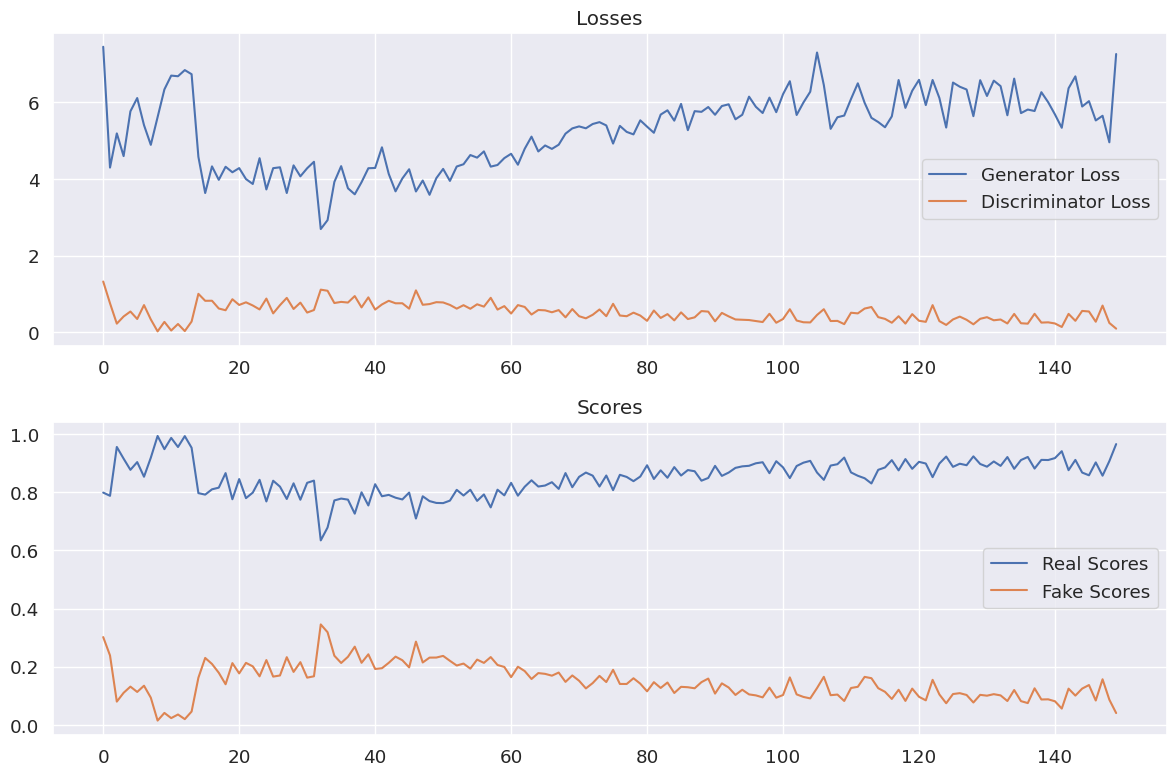

100%|██████████| 150/150 [6:24:39<00:00, 153.86s/it]


In [9]:
epochs = 150
losses = fit(model, criterion, train_dataloader, epochs, lr, device)

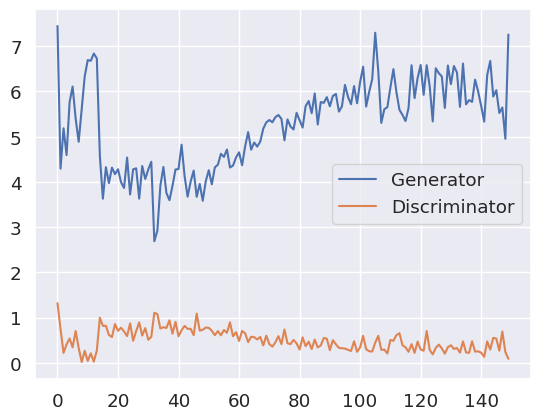

In [10]:
plt.plot(np.arange(epochs), losses['losses_g'], label='Generator')
plt.plot(np.arange(epochs), losses['losses_d'], label='Discriminator')
plt.legend()
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [11]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

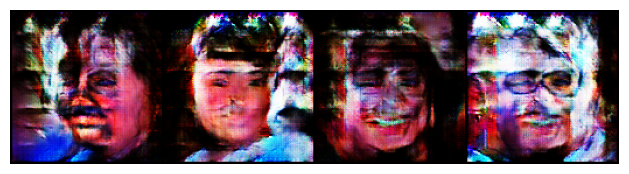

In [12]:
def show_images(generated):
    generated = generated.cpu().detach()
    grid = make_grid(generated, nrow=n_images, normalize=True)
    npimg = grid.numpy()

    plt.figure(figsize=(n_images * 2, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [14]:
num_images = 500

In [15]:
generator.eval()
fake_images = generator(torch.randn(num_images,latent_size, 1, 1, device=device))
real_images = [train_dataloader.dataset[i][0] for i in range(num_images)]

In [16]:
reshaped_fake = fake_images.reshape(fake_images.shape[0], -1)
reshaped_real = torch.stack(real_images).reshape(fake_images.shape[0], -1)

In [17]:
X = torch.concat([reshaped_real.cpu(), reshaped_fake.cpu()]).detach().numpy()
y = torch.concat((torch.ones(num_images), torch.zeros(num_images))).numpy()

In [18]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=1),
                X,
                y,
                cv=LeaveOneOut(),
                n_jobs=-1
        )
scores.mean()

0.979

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [19]:
from sklearn.manifold import TSNE

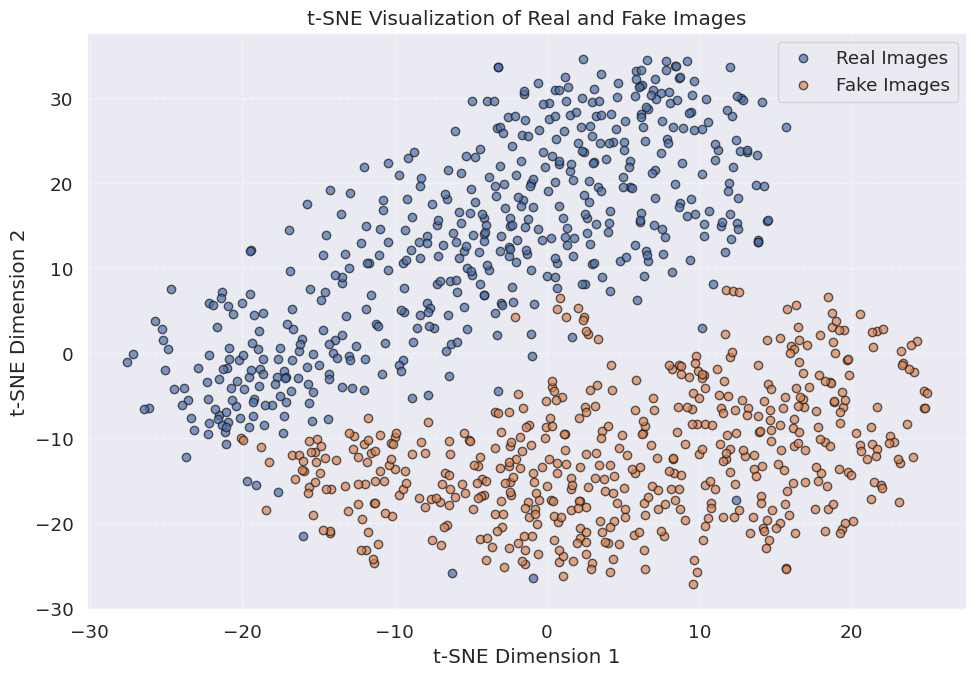

In [20]:
def plot_tsne(imgs, num_images, perplexity=30, learning_rate=200, n_iter=1000):
    
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    imgs_2d = tsne.fit_transform(imgs)

    real_2d = imgs_2d[:num_images]
    fake_2d = imgs_2d[num_images:]

    plt.figure(figsize=(10, 7))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real Images', alpha=0.7, edgecolor='k')
    plt.scatter(fake_2d[:, 0], fake_2d[:, 1], label='Fake Images', alpha=0.7, edgecolor='k')
    plt.title("t-SNE Visualization of Real and Fake Images")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_tsne(X, num_images)


Прокомментируйте получившийся результат: